### BNN Model for Complex Nonlinear Data

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
tfd = tfp.distributions
tfpl = tfp.layers
plt.rcParams['figure.figsize'] = (10, 6)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop

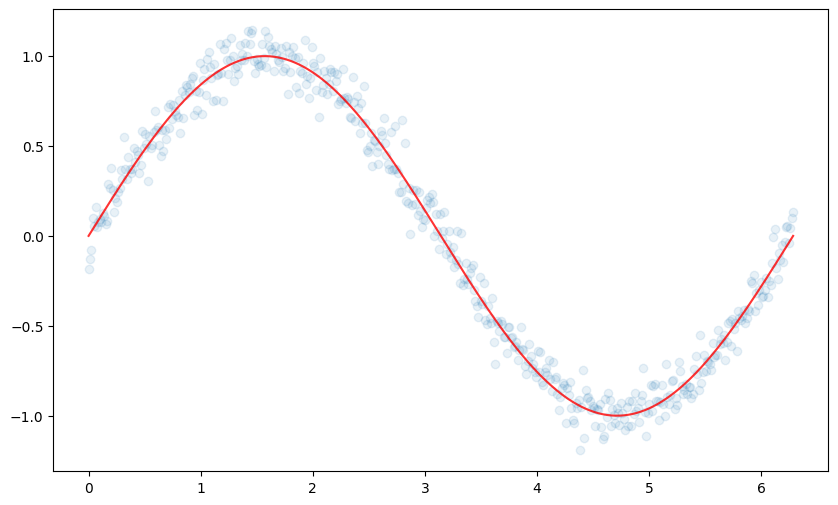

In [2]:
rng = np.random.RandomState(22)  
X_train = np.linspace(0, 2 * np.pi, num=500)
noise = np.random.normal(scale=0.08, size=X_train.size)
signal = np.sin(X_train)
y_train = np.sin(X_train) + noise
plt.plot(X_train, signal, color='red', alpha=0.8)
plt.scatter(X_train, y_train, alpha=0.1)
plt.show()

In [ ]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))),
    ])
    return prior_model


# Define the variational posterior weight distribution -- Multivariate Gaussian

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

In [ ]:
# Create probabilistic regression with one hidden layer weight uncertainty

model = Sequential([
    tfpl.DenseVariational(units=8,
                          input_shape=(1, ),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/X_train.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/X_train.shape[0]),
    tfpl.IndependentNormal(1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.summary()

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational (DenseVar  (None, 8)                152       
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 2)                189       
 ariational)                                                     
                                                                 
 independent_normal (Indepen  ((None, 1),              0         
 dentNormal)                  (None, 1))                         
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=1000, verbose=False)
model.evaluate(X_train, y_train)

16/16 [==============================] - 1s 3ms/step - loss: 0.0895


0.08945699781179428

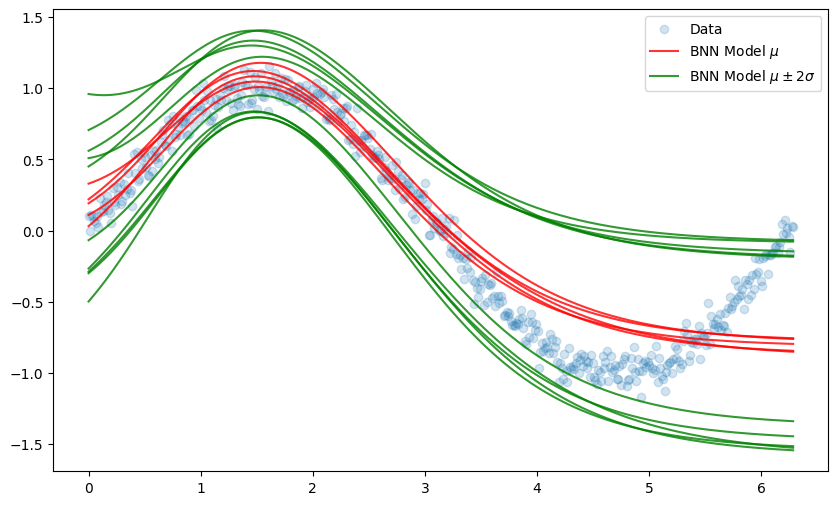

In [ ]:
# Plot an ensemble of trained probabilistic regressions

plt.scatter(X_train, y_train, alpha=0.2, label='Data')

for _ in range(5):
    y_model = model(X_train)
    y_hat = y_model.mean()
    y_hat_m2std = y_hat - 2 * y_model.stddev()
    y_hat_p2std = y_hat + 2 * y_model.stddev()
    
    if _ == 0:
        plt.plot(X_train, y_hat, color='red', alpha=0.8, label='BNN Model $\mu$')
        plt.plot(X_train, y_hat_m2std, color='green', alpha=0.8, label='BNN Model $\mu \pm 2 \sigma$')
        plt.plot(X_train, y_hat_p2std, color='green', alpha=0.8)
    else:
        plt.plot(X_train, y_hat, color='red', alpha=0.8)
        plt.plot(X_train, y_hat_m2std, color='green', alpha=0.8)
        plt.plot(X_train, y_hat_p2std, color='green', alpha=0.8)
plt.legend(loc='best')
plt.show()